# Synthetic Model
use gaussian model to simultate training and learning dataset. use compression and error correcting code to handle the single label classification problem.

## Data Generation
Y -> label: L dimension one hot vector. each entry represent a class.

X -> featues: $4\times L$ dimentsion. mean=Bernouli($\frac{1}{2}$), variance = var.

## Training Process
We compress the label Y into binary representation of $\hat Y=\{0,1\}^{\hat L}$ where $\hat L = \log L$. Then train a bianry regressor on each bit of $\hat Y$.

In the testing process, we view the classifier as a Binary Erasure Channel and threshold the score of each label.


In [104]:
BIT_LABEL = 8
DIM_LABEL = 2**8
DIM_FEATURE = DIM_LABEL*4
VARIANCE = 0.8
THRESHOLD = 0.25
NUM_DATA = 10000
SEED = 0

In [105]:
# genetate synthetic data
import numpy as np
from numpy.random import binomial
from numpy.random import normal
from numpy.random import randint
np.random.seed(SEED)
X_mean = binomial(n=1, p=0.5, size=(DIM_LABEL, DIM_FEATURE))#genrate mean of each class
Y = randint(DIM_LABEL, size=(NUM_DATA))
X = np.array([normal(X_mean[y], scale=VARIANCE) for y in Y])

from util import num_to_bin
Y_bin = np.array([num_to_bin(y, BIT_LABEL) for y in Y]) # compress Y into binary format

#split training and test data set
from sklearn.model_selection import train_test_split
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y_bin, test_size=0.33)

In [106]:
# train OvsA classifiers on raw data
from sklearn.linear_model import LogisticRegression
def train_bit(bit):
    clf = LogisticRegression(solver='sag')
    clf.fit(y=Y_tr[:, bit], X=X_tr)
    return clf

In [107]:
from joblib import Parallel, delayed # Multitread
origin_clfs = Parallel(n_jobs=-1)(delayed(train_bit)( i) for i in range(Y_tr.shape[1]))

In [108]:
Y_prob = np.array([clf.predict_proba(X_te)[:,1] for clf in origin_clfs]).T
Y_pred = np.array([clf.predict(X_te) for clf in origin_clfs]).T

In [109]:
(Y_pred==Y_te).sum()/float(Y_te.shape[0]*Y_te.shape[1])

0.82897727272727273

In [110]:
# test the accuracy of threshold data, 0.5 if it is erased
acc = []
erase = []
for clip in np.arange(0.01, 0.5, 0.01):
    Y_clip = np.apply_along_axis(lambda row: \
                        np.array([0 if x < clip else 1 if x>1-clip else 0.5 for x in row]), \
                        0, Y_prob)
    acc.append((Y_clip==Y_te).sum()/float((Y_clip!=0.5).sum()))
    erase.append((Y_clip==0.5).sum()/float(Y_te.shape[0]*Y_te.shape[1]))

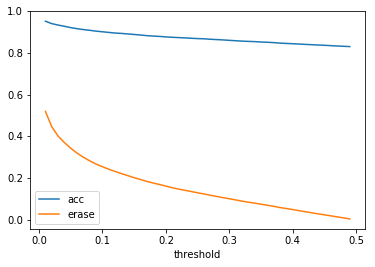

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(0.01, 0.5, 0.01), acc, label='acc')
plt.plot(np.arange(0.01, 0.5, 0.01), erase, label='erase')
plt.xlabel('threshold')
plt.legend()

In [91]:
from reedsolo import RSCodec, ReedSolomonError

In [138]:
rs = RSCodec()

In [139]:
list(rs.decode(rs.encode([0,1,1,0])))

[]